# Time-series data and application to stock markets {-}

This project aims at dealling with time-series data analysis and its application to stock markets. Datasets will be worked on are Nasdaq and Vietnam stock datasets.



In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# access google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Code for APPL stock price prediction 

In [ ]:

file_path = '/content/drive/MyDrive/AAPL.csv'  
data_appl = pd.read_csv(file_path)


In [ ]:
# Show some first data samples
data_appl.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,12-12-1980,0.128348,0.128348,469033600,0.128906,0.128348,0.099874
1,15-12-1980,0.121652,0.122210,175884800,0.122210,0.121652,0.094663
2,16-12-1980,0.112723,0.113281,105728000,0.113281,0.112723,0.087715
3,17-12-1980,0.115513,0.115513,86441600,0.116071,0.115513,0.089886
4,18-12-1980,0.118862,0.118862,73449600,0.119420,0.118862,0.092492


In [ ]:
# Get some info about the data
data_appl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10590 entries, 0 to 10589
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            10590 non-null  object 
 1   Low             10590 non-null  float64
 2   Open            10590 non-null  float64
 3   Volume          10590 non-null  int64  
 4   High            10590 non-null  float64
 5   Close           10590 non-null  float64
 6   Adjusted Close  10590 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 579.3+ KB


In [ ]:
### Split the dataset into time windows to get data samples.

df=data_appl
X_data = []
y_data = []
window_size=30 # Time window for data feature (size of 'number of days').

# Only get the open price (index 2 in the data frame)
for i in range(1, len(df) - window_size - 1):
    first = df.iloc[i, 2]
    data_feature = []
    data_label = []
    
    # Get a window_size time frame for data feature
    for j in range(window_size):
        data_feature.append(df.iloc[i + j, 2])
        
    # Next value is the label (price of the next day) to be predicted
    data_label.append(df.iloc[i + window_size, 2])
    
    # Append new data sample (feature and label) to X_data and y_data
    X_data.append(np.array(data_feature).reshape(window_size, 1))
    y_data.append(np.array(data_label))


In [ ]:
### Split the data into training, validation and test set

# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

# Print shape of the training, validation and test set
print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)

Shape of training set:  (6756, 30, 1)
Shape of validation set:  (1690, 30, 1)
Shape of test set:  (2112, 30, 1)


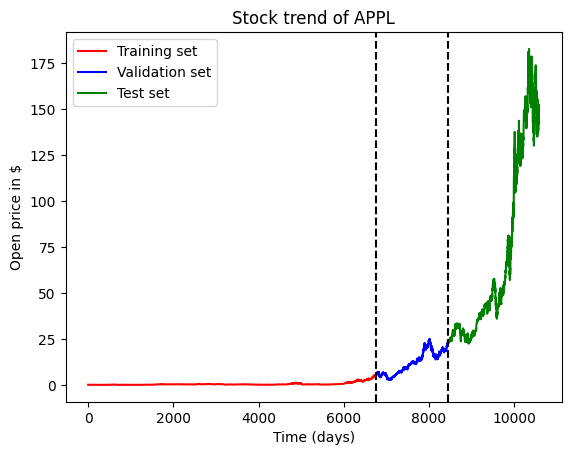

In [ ]:
# Visualize the training, validation and test set
df_plot = df['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

# Plot the subset splits
ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend of APPL")
plt.xlabel('Time (days)')
plt.ylabel('Open price in $')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.show()

In [ ]:
# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm = X_train.copy()
y_train_norm = y_train.copy()
for i in range(0, len(X_train)):
    min_feature = np.min(X_train[i])
    max_feature = np.max(X_train[i])
    X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
    y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

# MinMax normalize the validation data: x=(x-min(x)/(max(x)-min(x))
X_val_norm = X_val.copy()
y_val_norm = y_val.copy()
for i in range(0, len(X_val)):
    min_feature = np.min(X_val[i])
    max_feature = np.max(X_val[i])
    X_val_norm[i] = (X_val[i] - min_feature) / (max_feature - min_feature)
    y_val_norm[i] = (y_val[i] - min_feature) / (max_feature - min_feature)

In [ ]:
### Create and train the model

# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Build the model architecture
model = tf.keras.Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, 1), padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1)) # By default: activation='linear', i.e., passing through f(x) = x

# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=5, batch_size=512)

Epoch 1/5
14/14 [==============================] - 2s 85ms/step - loss: 0.5855 - mse: 0.5855 - val_loss: 0.1760 - val_mse: 0.1760
Epoch 2/5
14/14 [==============================] - 1s 69ms/step - loss: 0.1672 - mse: 0.1672 - val_loss: 0.1268 - val_mse: 0.1268
Epoch 3/5
14/14 [==============================] - 1s 79ms/step - loss: 0.1347 - mse: 0.1347 - val_loss: 0.0929 - val_mse: 0.0929
Epoch 4/5
14/14 [==============================] - 2s 128ms/step - loss: 0.0967 - mse: 0.0967 - val_loss: 0.0905 - val_mse: 0.0905
Epoch 5/5
14/14 [==============================] - 2s 124ms/step - loss: 0.0815 - mse: 0.0815 - val_loss: 0.0774 - val_mse: 0.0774


In [ ]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

In [ ]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))


66/66 [==============================] - 0s 3ms/step
MSE on the test set:  0.07790484832322128


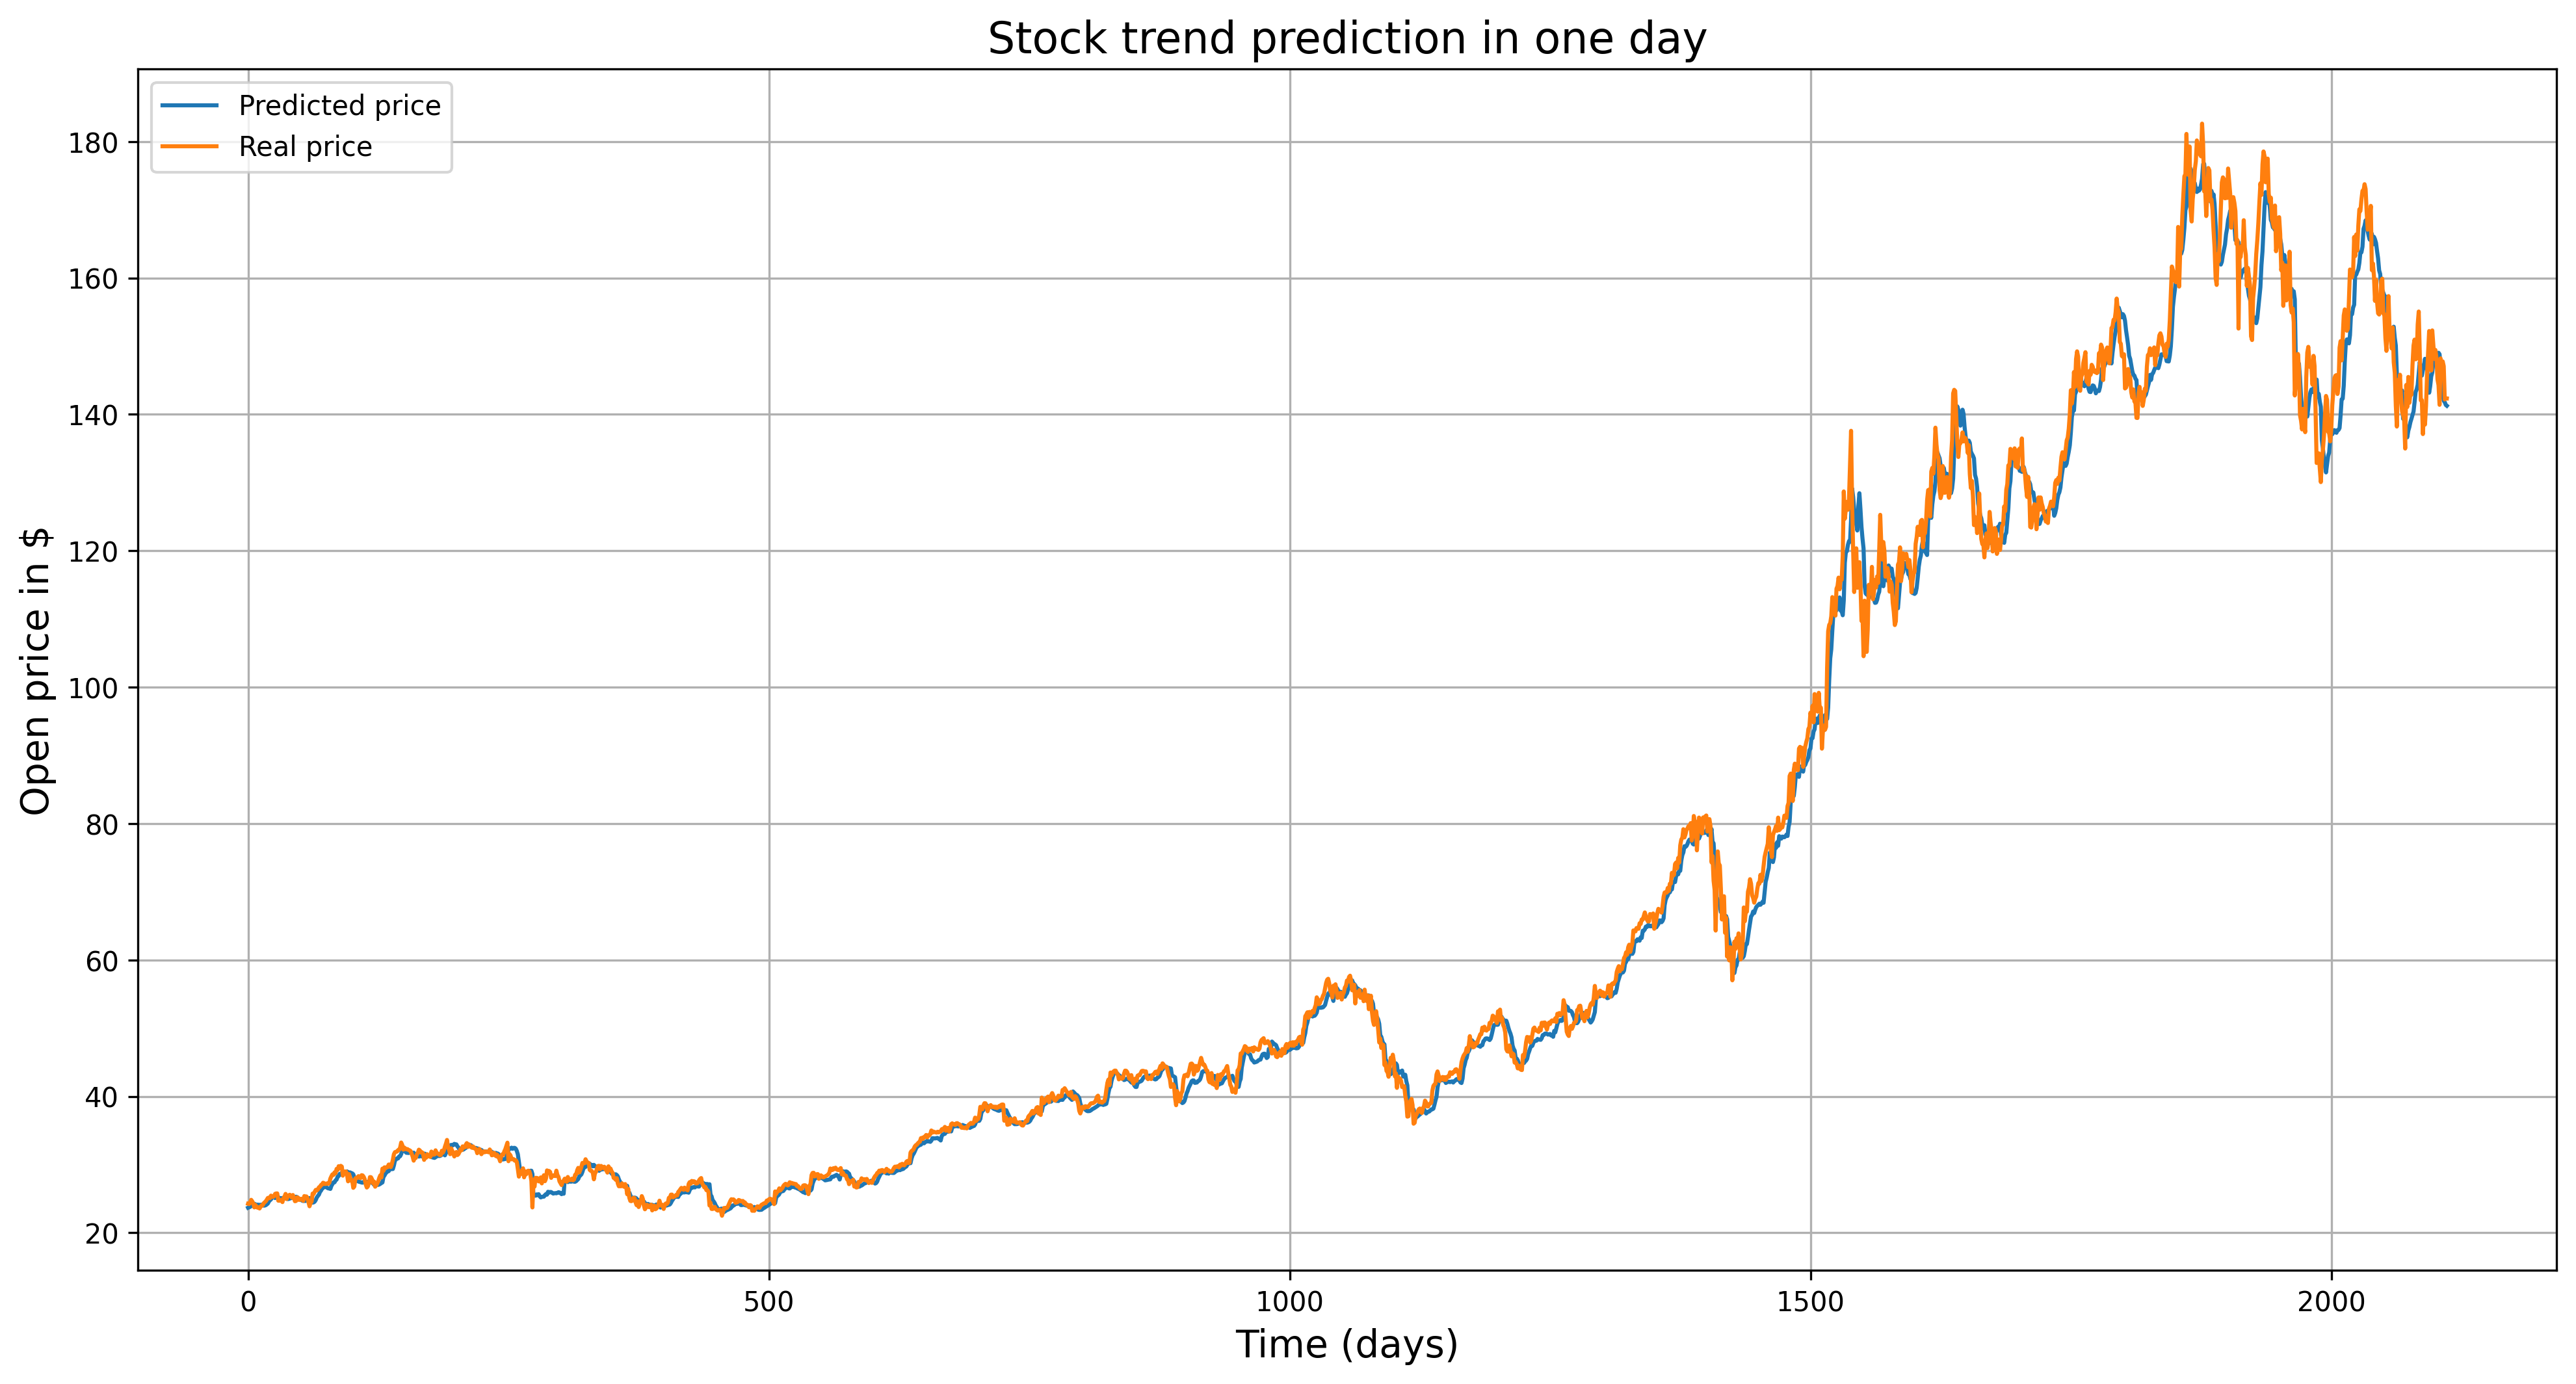

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize predicted stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

### trainning model using historical data of top  tech companies in term of market capital.

In [ ]:
# import library
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:

# Define the folder path containing the CSV files
folder_path = '/content/drive/MyDrive/top-tech'

# Initialize an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Iterate through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # Load the CSV file into a DataFrame
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath)

        # Convert the "Date" column to datetime format
        df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

        # Filter the data from 14/01/2020 onwards
        start_date = pd.to_datetime('14-01-2020', format='%d-%m-%Y')
        df = df[df['Date'] >= start_date]

        # Append the DataFrame to the combined_data DataFrame using a join operation
        if combined_data.empty:
            combined_data = df
        else:
            combined_data = combined_data.merge(df, on='Date', how='outer')

# print info
print(combined_data.info())
# Reset the index of the combined DataFrame
combined_data.reset_index(drop=True, inplace=True)
# Exclude the "TradingDate" column from the combined_data DataFrame
combined_data = combined_data.iloc[:, 1:]
# Normalize the data using Min-Max scaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(combined_data.iloc[:, 1:])  # Exclude the "Date" column from scaling
# show scalered-data
print(scaled_data)

# Define the window size
window_size = 30
# Split the data into input features and target variable
X = []
y = []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i])
    y.append(scaled_data[i])

X = np.array(X)
y = np.array(y)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 735 entries, 0 to 734
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              735 non-null    datetime64[ns]
 1   Low_x             735 non-null    float64       
 2   Open_x            735 non-null    float64       
 3   Volume_x          735 non-null    int64         
 4   High_x            735 non-null    float64       
 5   Close_x           735 non-null    float64       
 6   Adjusted Close_x  735 non-null    float64       
 7   Low_y             735 non-null    float64       
 8   Open_y            735 non-null    float64       
 9   Volume_y          735 non-null    int64         
 10  High_y            735 non-null    float64       
 11  Close_y           735 non-null    float64       
 12  Adjusted Close_y  735 non-null    float64       
 13  Low_x             735 non-null    float64       
 14  Open_x            735 non-

<ipython-input-313-b5c72ac263d7>:25: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Open_x', 'Low_x', 'Volume_x', 'Close_x', 'Adjusted Close_x', 'High_x'} in the result is deprecated and will raise a MergeError in a future version.
  combined_data = combined_data.merge(df, on='Date', how='outer')


In [ ]:
# Split the data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)
# print shape of each set
print("shape of X_train:", X_train.shape)
print("shape of y_test:", y_test.shape)




shape of X_train: (451, 30, 23)
shape of y_test: (141, 23)


In [ ]:

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, X_train.shape[2])))
model.add(Dense(y_train.shape[1]))

# Compile the model
model.compile(loss='mse', optimizer='adam')

# Train the model with validation set
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))



Epoch 1/50
15/15 [==============================] - 3s 54ms/step - loss: 0.1583 - val_loss: 0.0766
Epoch 2/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0205 - val_loss: 0.0341
Epoch 3/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0106 - val_loss: 0.0266
Epoch 4/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0068 - val_loss: 0.0233
Epoch 5/50
15/15 [==============================] - 0s 19ms/step - loss: 0.0054 - val_loss: 0.0211
Epoch 6/50
15/15 [==============================] - 0s 21ms/step - loss: 0.0047 - val_loss: 0.0203
Epoch 7/50
15/15 [==============================] - 0s 17ms/step - loss: 0.0043 - val_loss: 0.0202
Epoch 8/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0042 - val_loss: 0.0188
Epoch 9/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0040 - val_loss: 0.0195
Epoch 10/50
15/15 [==============================] - 0s 31ms/step - loss: 0.0038 - val_loss: 0.0184
Epoch 11/

In [ ]:
### Make prediction on the test set
# Make predictions on the test set
predictions = model.predict(X_test)
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test[2], predictions[2])
print(predictions[2])
print(y_test[2])
# Print the MSE
print('Mean Squared Error (MSE):', mse)



5/5 [==============================] - 0s 6ms/step
[0.42693412 0.31691274 0.4752589  0.5839929  0.58291346 0.27849272
 0.20107983 0.15248427 0.2564363  0.32746276 0.30341417 0.55049366
 0.5110502  0.28532356 0.59265023 0.59869766 0.628491   0.46474618
 0.33095947 0.33032882 0.42059714 0.3821472  0.3699768 ]
[0.6481171  0.17443622 0.67293241 0.67049861 0.67534081 0.21584833
 0.20528043 0.24982047 0.20065751 0.22332591 0.22332591 0.59428651
 0.58344983 0.22032435 0.5930654  0.61196976 0.61506703 0.41727536
 0.38638233 0.5002548  0.40350698 0.42383895 0.42400027]
Mean Squared Error (MSE): 0.009086882165107021


Mean Squared Error (MSE) after inverse: 204177949022784.4


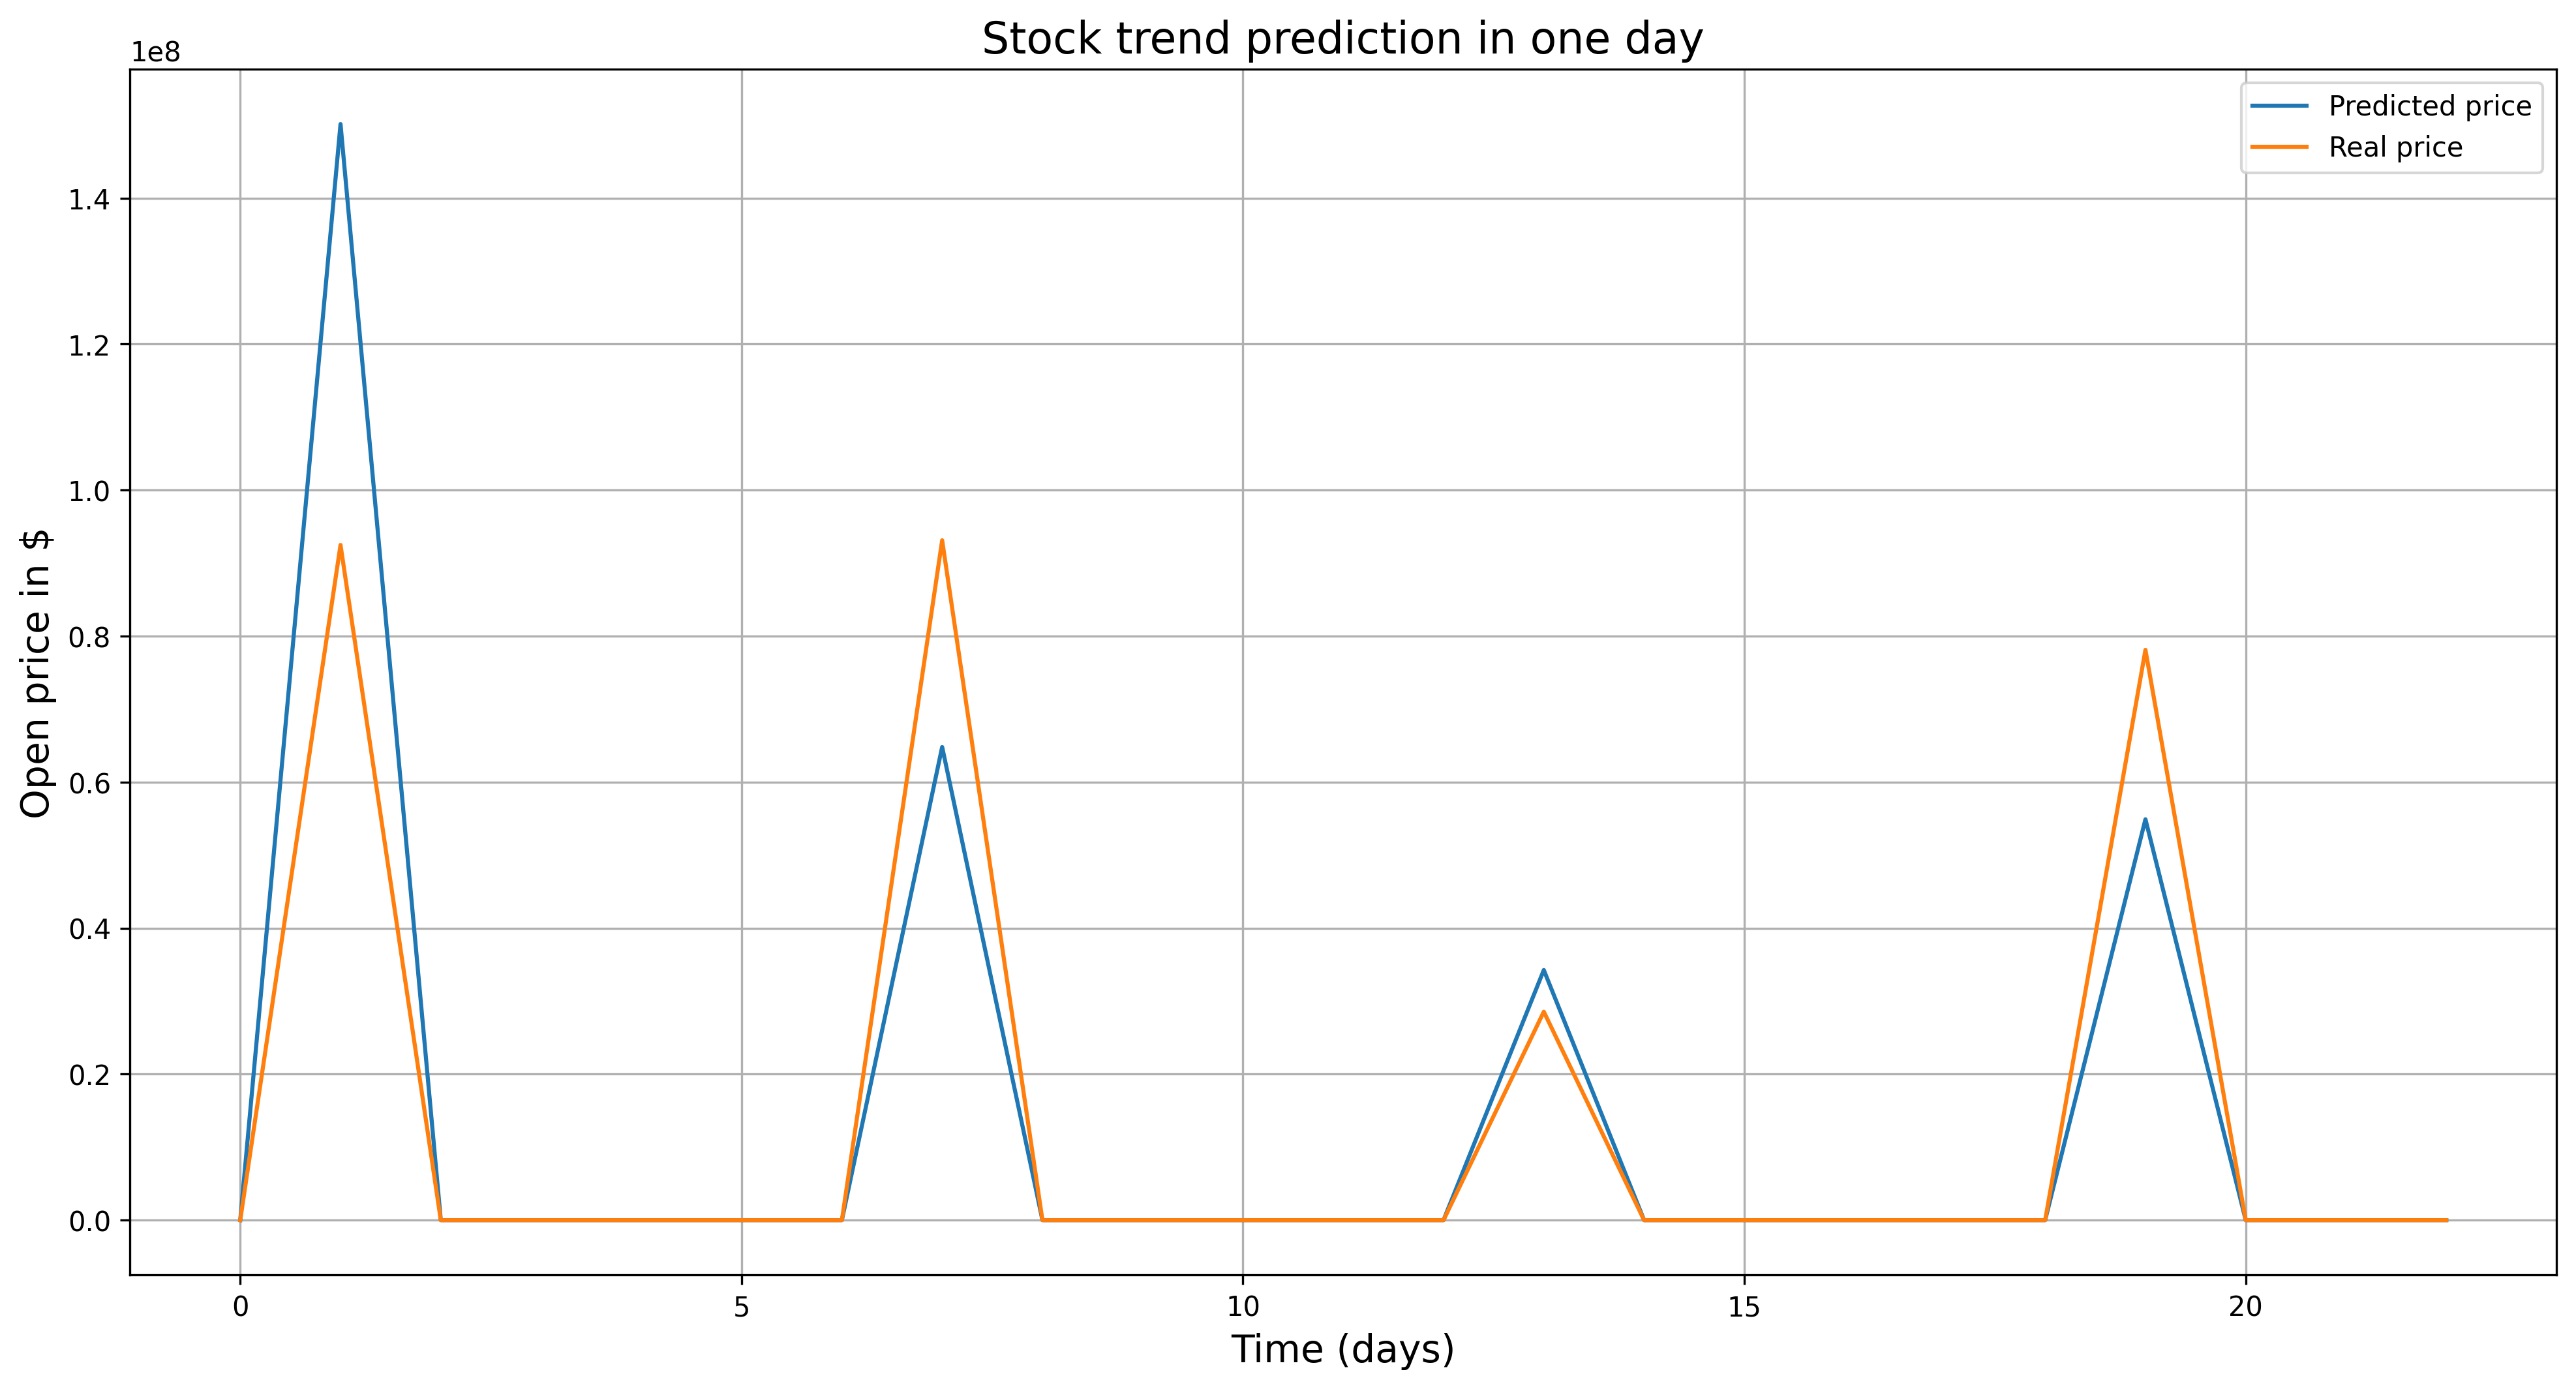

In [ ]:

# Perform inverse scaling on the predictions
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
# Visualize predicted stock price versus real stock price for  Open price of APPL
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(predictions[2], label='Predicted price')
plt.plot(y_test[2], label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
# Save the plot as an image in the "top-tech" folder on Google Drive
plt.savefig('/content/drive/MyDrive/top-tech/APPL-open-price-prediction_plot.png')
plt.show()

### Build Vietnam stock price prediction with 5 famous tech company

In [ ]:

# Define the folder path containing the CSV files
folder_path = '/content/drive/MyDrive/top-tech-vn'

# Initialize an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Iterate through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # Load the CSV file into a DataFrame
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath)

        # Exclude the first column (Unnamed)
        df = df.iloc[:, 1:]
        df['TradingDate'] = pd.to_datetime(df['TradingDate'])

        # Filter the data from 14th January 2020 onwards
        start_date = pd.to_datetime('01/14/2020', format='%m/%d/%Y')
        df = df[df['TradingDate'] >= start_date]

        # Append the DataFrame to the combined_data DataFrame using a join operation
        if combined_data.empty:
            combined_data = df
        else:
            combined_data = combined_data.merge(df, on='TradingDate', how='outer')
print("info of the data:", combined_data.info())
# Exclude the "TradingDate" column from the combined_data DataFrame
combined_data = combined_data.iloc[:, 5:]
# Reset the index of the combined DataFrame
combined_data.reset_index(drop=True, inplace=True)

# Normalize the data using Min-Max scaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(combined_data.iloc[:, 1:])  # Exclude the "TradingDate" column from scaling
# Define the window size
window_size = 30
# Split the data into input features and target variable
X = []
y = []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i])
    y.append(scaled_data[i])


X = np.array(X)
y = np.array(y)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 779 entries, 0 to 778
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Open_x       779 non-null    float64       
 1   High_x       779 non-null    float64       
 2   Low_x        779 non-null    float64       
 3   Close_x      779 non-null    float64       
 4   Volume_x     779 non-null    int64         
 5   TradingDate  779 non-null    datetime64[ns]
 6   Open_y       779 non-null    float64       
 7   High_y       779 non-null    float64       
 8   Low_y        779 non-null    float64       
 9   Close_y      779 non-null    float64       
 10  Volume_y     779 non-null    int64         
 11  Open_x       779 non-null    float64       
 12  High_x       779 non-null    float64       
 13  Low_x        779 non-null    float64       
 14  Close_x      779 non-null    float64       
 15  Volume_x     779 non-null    int64         
 16  Open_y  

<ipython-input-318-206abff12585>:26: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Open_x', 'Low_x', 'Volume_x', 'Close_x', 'High_x'} in the result is deprecated and will raise a MergeError in a future version.
  combined_data = combined_data.merge(df, on='TradingDate', how='outer')


In [ ]:
# Split the data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)
# print shape of each set
print("shape of X_train:", X_train.shape)
print("shape of y_test:", y_test.shape)



shape of X_train: (479, 30, 20)
shape of y_test: (150, 20)


In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, X_train.shape[2])))
model.add(Dense(y_train.shape[1]))

# Compile the model
model.compile(loss='mse', optimizer='adam')

# Train the model with validation set
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))



Epoch 1/50
15/15 [==============================] - 3s 54ms/step - loss: 0.0866 - val_loss: 0.0320
Epoch 2/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0118 - val_loss: 0.0188
Epoch 3/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0066 - val_loss: 0.0149
Epoch 4/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0053 - val_loss: 0.0124
Epoch 5/50
15/15 [==============================] - 0s 19ms/step - loss: 0.0047 - val_loss: 0.0115
Epoch 6/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0044 - val_loss: 0.0113
Epoch 7/50
15/15 [==============================] - 0s 19ms/step - loss: 0.0042 - val_loss: 0.0104
Epoch 8/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0039 - val_loss: 0.0103
Epoch 9/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0038 - val_loss: 0.0102
Epoch 10/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0037 - val_loss: 0.0096
Epoch 11/

In [ ]:
### Make prediction on the test set
# Make predictions on the test set
predictions = model.predict(X_test)
# Calculate Mean Squared Error (MSE) for open price of CMG ticker
mse = mean_squared_error(y_test[0], predictions[0])
print(predictions[0])
print(y_test[0])
# Print the MSE
print('Mean Squared Error (MSE):', mse)



5/5 [==============================] - 0s 6ms/step
[0.81819785 0.8128452  0.7901596  0.7849179  0.1520053  0.72332984
 0.683343   0.76717466 0.74175584 0.05285685 0.30784088 0.31433845
 0.36590832 0.32330158 0.02434705 0.51387435 0.46129704 0.5346054
 0.5253812  0.17702046]
[8.64560482e-01 8.42124682e-01 8.59808592e-01 8.45761223e-01
 1.10573803e-01 6.88869284e-01 6.34323124e-01 7.36591850e-01
 6.95431472e-01 2.68277946e-02 3.23366708e-01 3.03028975e-01
 3.38162955e-01 3.30256132e-01 9.96363274e-05 5.26315789e-01
 4.98327759e-01 5.42207792e-01 5.29605263e-01 3.62997495e-01]
Mean Squared Error (MSE): 0.002929485866494697


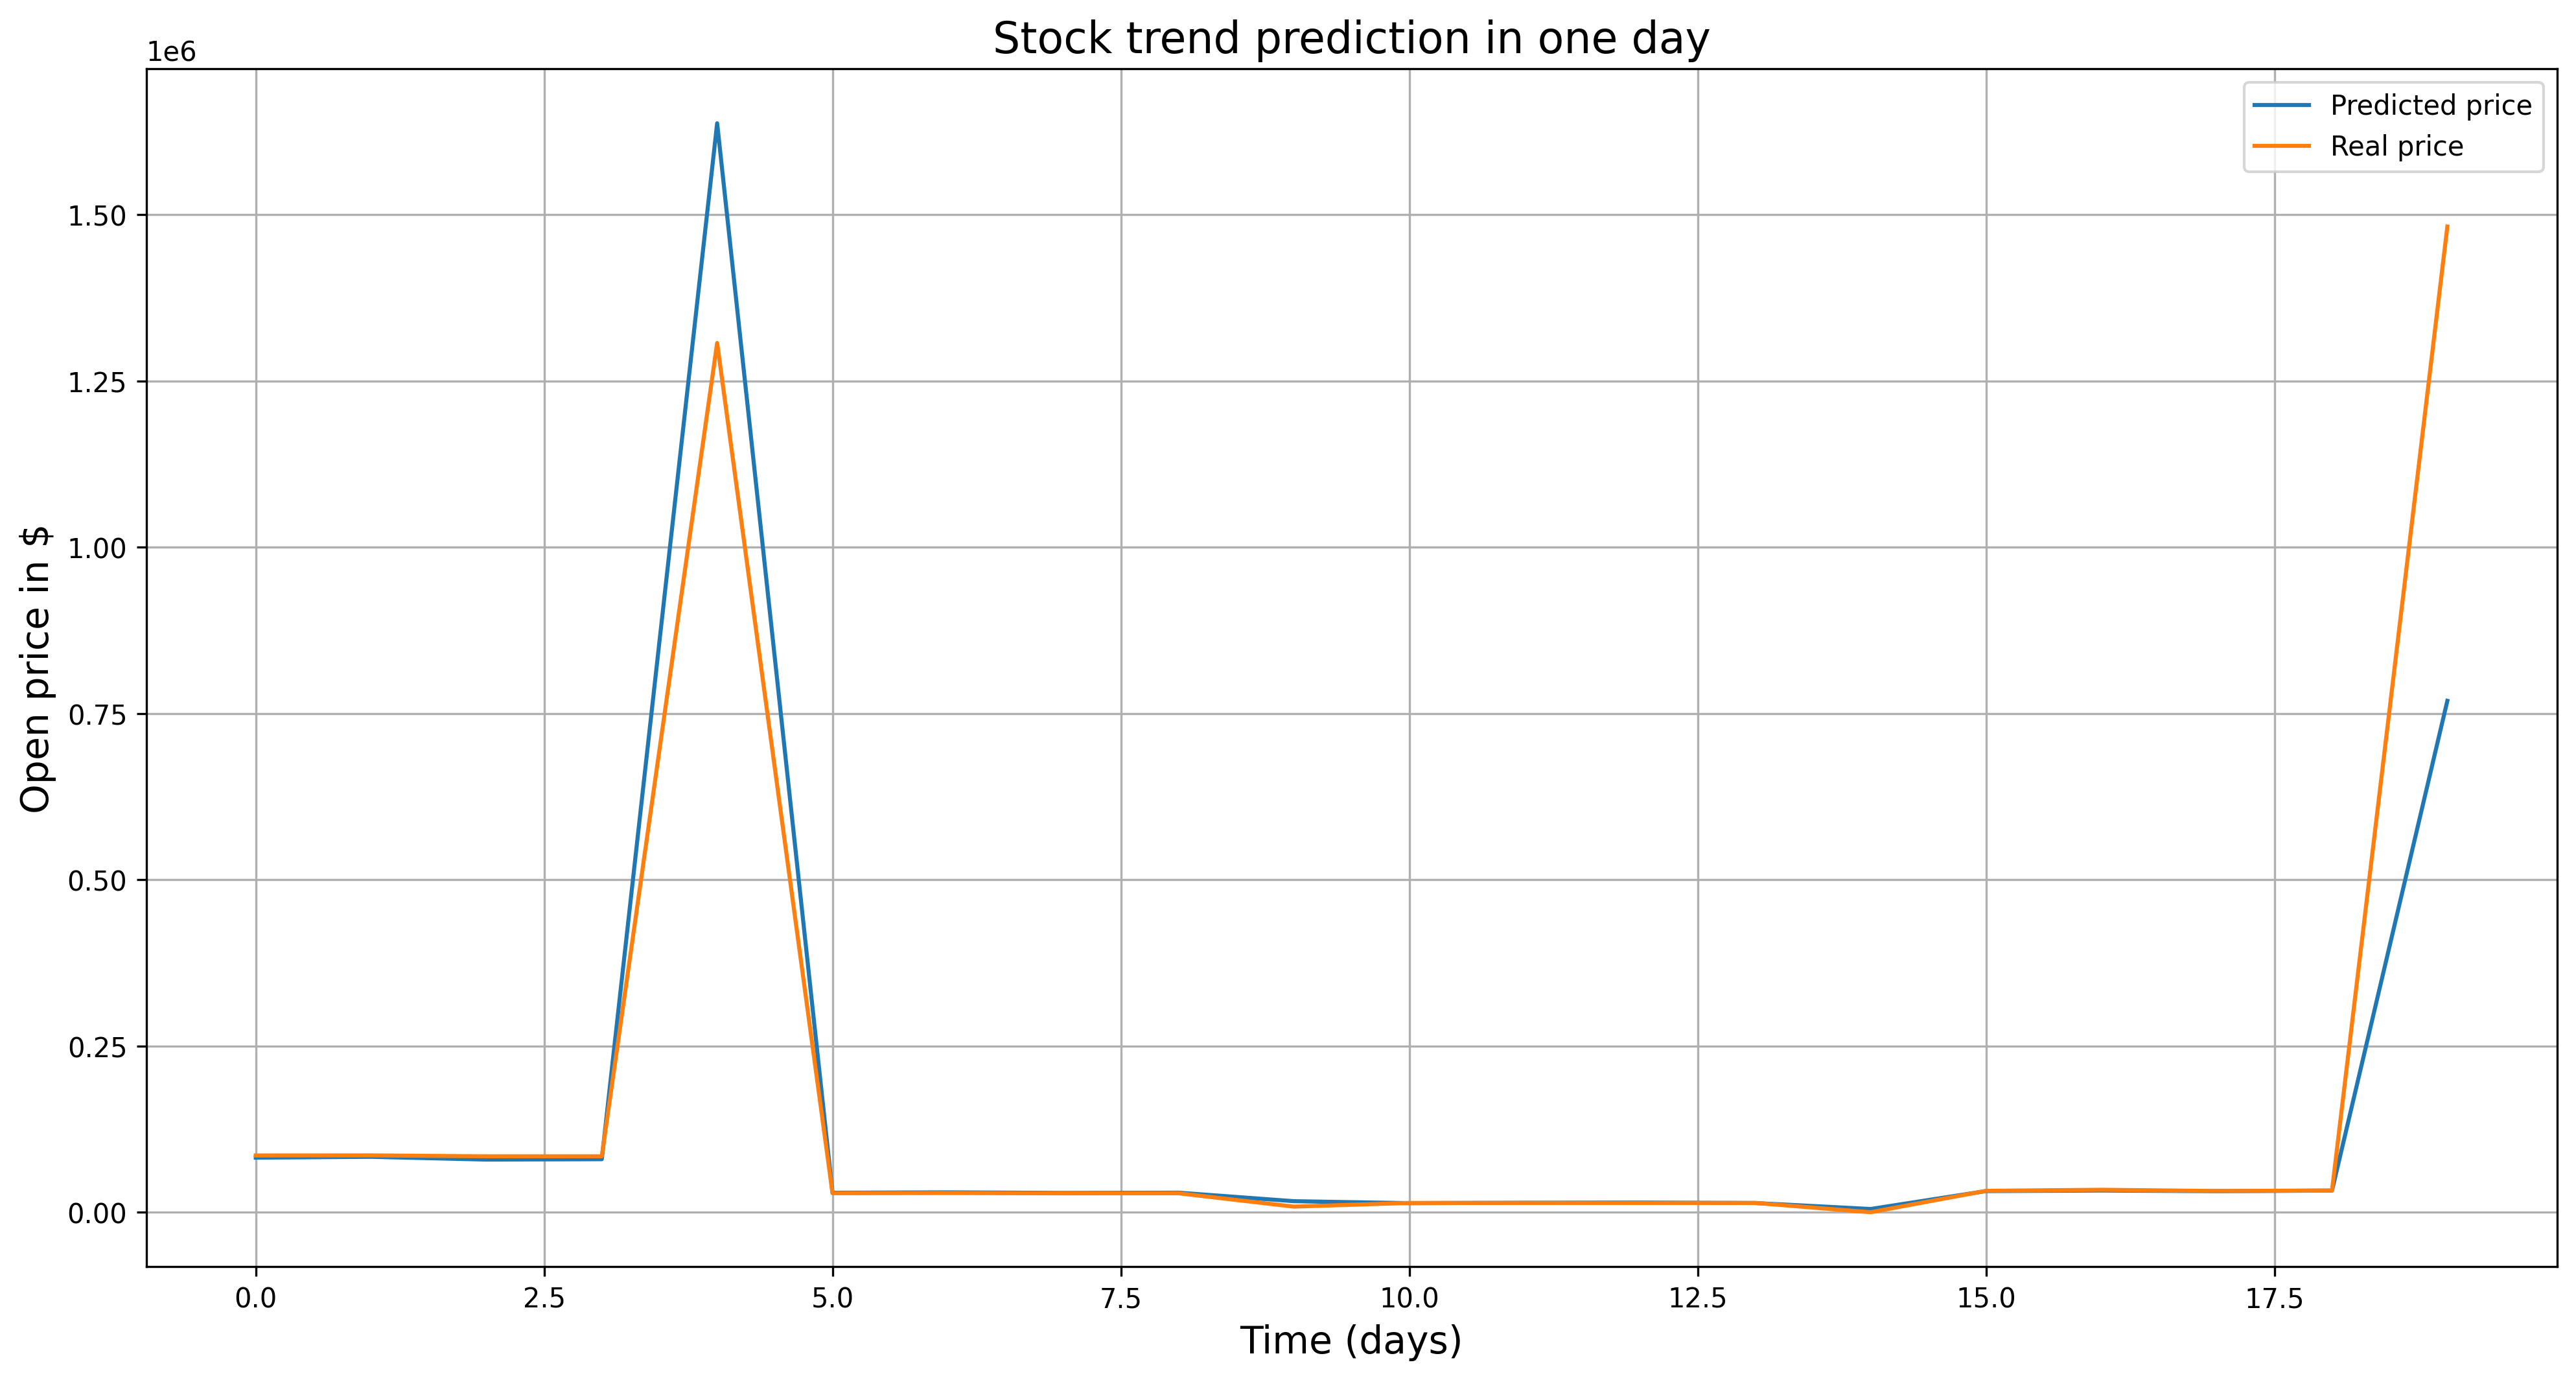

In [ ]:
# Perform inverse scaling on the predictions
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
# Visualize predicted stock price versus real stock price for  Open price of APPL
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(predictions[0], label='Predicted price')
plt.plot(y_test[0], label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
# Save the plot as an image in the "top-tech" folder on Google Drive
plt.savefig('/content/drive/MyDrive/top-tech-vn/CMG-open-price-prediction_plot.png')
plt.show()

In [ ]:
### Trading point with MA
# Calculate Moving Average
ma_period = 50  # Define the moving average period
test_data = df['MA'] = test_data['Close'].rolling(window=ma_period).mean()

# Generate Trading Signals
test_data['Signal'] = 0
test_data.loc[test_data['Close'] > test_data['MA'], 'Signal'] = 1  # Buy signal
test_data.loc[test_data['Close'] < test_data['MA'], 'Signal'] = -1  # Sell signal

# Visualize the Trading Signals
plt.figure(figsize=(16, 8))
plt.plot(test_data['Close'], label='Close Price')
plt.plot(test_data['MA'], label='Moving Average')
plt.scatter(test_data.index, test_data[test_data['Signal'] == 1]['Close'], marker='^', color='green', label='Buy Signal')
plt.scatter(test_data.index, test_data[test_data['Signal'] == -1]['Close'], marker='v', color='red', label='Sell Signal')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Moving Average Trading Signals')
plt.legend()
plt.show()
